In [ ]:
#@title Fix variables, constants
%%capture
import torch
precision = 1
torch.set_printoptions(precision=precision)
WIDTH, HEIGHT = 40,40
grid_size = (WIDTH, HEIGHT)
print("Width and Height used are {} and {}".format(WIDTH, HEIGHT))
INIT_PROBABILITY = 0.1
min_pixels = max(0, int(WIDTH * HEIGHT * INIT_PROBABILITY))
NUM_LAYERS = 2 # rest hidden and one alpha
ALPHA = 0.6 # To make other cells active (we dont go with other values below 0.6 to avoid dead cells and premature livelihood)
INHERTIANCE_PROBABILITY  = 0.2 # probability that neighboring cells will inherit by perturbation.
parameter_perturbation_probability = 0.2
print("Numbers of layers used are {}".format(NUM_LAYERS))
print("1 for alpha layer and rest {} for hidden".format(NUM_LAYERS-1))
NUM_STEPS = 90
num_steps = NUM_STEPS
print("Numbers of Time Steps are {}".format(NUM_STEPS))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
activation = 'sigmoid' # ['relu','sigmoid','tanh','leakyrelu']
frequency_dicts = []
FPS = 2 # Speed of display for animation of NCA and plots
marker_size = 2 # for plots
everystep_weights = [] # Stores weigths of the NNs from every time step.
KMEANS_K = 5

In [ ]:
#@title Simulation with debug
%%capture
import torch
import os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import random
import copy
from collections import Counter
from matplotlib.colors import Normalize

ca_grids_for_later_analysis = []

# def custom_activation(x):
#     result = 0.05 * (x + 2)
#     result = max(0, min(0.1, result))
#     return result
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

if(activation == 'sigmoid'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.sigmoid = nn.Sigmoid()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.sigmoid(x)
          x = self.fc2(x)
          return x

elif(activation == 'tanh'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.tanh = nn.Tanh()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.tanh(x)
          x = self.fc2(x)
          return x


elif(activation == 'relu'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.relu = nn.ReLU()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.relu(x)
          x = self.fc2(x)
          return x
else:
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.leaky_relu = nn.LeakyReLU()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.leaky_relu(x)
          x = self.fc2(x)
          return x


ca_nn = SimpleNN().to(DEVICE)

# Calculate the number of parameters stepwise

input_size_fc1 = 9 * NUM_LAYERS
output_size_fc1 = NUM_LAYERS
weight_params_fc1 = input_size_fc1 * output_size_fc1
bias_params_fc1 = output_size_fc1

input_size_fc2 = NUM_LAYERS
output_size_fc2 = NUM_LAYERS
weight_params_fc2 = input_size_fc2 * output_size_fc2
bias_params_fc2 = output_size_fc2

weight_params = weight_params_fc1 + weight_params_fc2
bias_params = bias_params_fc1 + bias_params_fc2
total_params = weight_params + bias_params

print("------------------------------------------------------------------")
print("Model Summary")
# Print the equations and the total number of parameters
print(f"Input Size: {input_size_fc1}")
print(f"FC Layer 1 Weight Parameters: {input_size_fc1} * {output_size_fc1} = {weight_params_fc1}")
print(f"FC Layer 1 Bias Parameters: {output_size_fc1}")
print(f"FC Layer 2 Weight Parameters: {input_size_fc2} * {output_size_fc2} = {weight_params_fc2}")
print(f"FC Layer 2 Bias Parameters: {output_size_fc2}")
print(f"Total Number of Parameters: {total_params}")
for name, layer in ca_nn.named_children():
    if isinstance(layer, nn.Linear):
        input_size = layer.in_features
        output_size = layer.out_features
        if name == "fc1":
            print(f"Layer 1: {name}, Input Size: {input_size}, Output Size: {output_size_fc1}")
        elif name == "fc2":
            print(f"Layer 2: {name}, Input Size: {input_size_fc2}, Output Size: {output_size_fc2}")

print("------------------------------------------------------------------")


ca_grid = torch.zeros((NUM_LAYERS, WIDTH, HEIGHT), device=DEVICE, dtype=torch.float32)
print("cagrid before")
print(ca_grid)
random_tensor = torch.ones((WIDTH, HEIGHT))
sorted_values, indices = random_tensor.view(-1).sort()
mask = torch.zeros_like(random_tensor)
shuffled_indices = indices.tolist()  # Convert indices to a list
random.shuffle(shuffled_indices)     # Shuffle the list
random_positions = shuffled_indices[:min_pixels]
mask.view(-1)[random_positions] = 1.0
for layer in range(0,NUM_LAYERS):
  if (layer==0):
    ca_grid[layer] = mask * (ALPHA + (1 - ALPHA) * random_tensor)  # Initialize the alpha channel with values greater than ALPHA
  else:
    ca_grid[layer] = mask * (ALPHA + (1 - ALPHA) * random_tensor * random.random())  # Initialize the other channel with values greater than ALPHA
# ca_grid[0] = mask * (random_tensor) # Initialising only alpha channel
# ca_grid[1] = mask * (random_tensor * random.random()) # Initialising a little amount of channel 1 with the idea that if a pixel is having some intensity in alpha, it should have some values in other channels.
print("cagrid after")
print(ca_grid)
print("------------------------------------------------------------------")

print("Weight Parameters:")

print("Individual Weight Parameters:")
for name, param in ca_nn.named_parameters():
    if 'weight' in name:
        print(f"Layer: {name}, Shape: {param.shape}")
        print(f"Weights: {param}")

print("------------------------------------------------------------------")
print("Bias Parameters for FC1:")
print(ca_nn.fc1.bias)
print("Bias Parameters for FC2:")
print(ca_nn.fc2.bias)

print("------------------------------------------------------------------")

print("Entering update loop >>>>>")

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
        nn.init.zeros_(module.bias)
def initialize_weights_to_zero(module):
    if isinstance(module, nn.Linear):
        nn.init.zeros_(module.weight)
        nn.init.zeros_(module.bias)

# Create a list of neural networks, one for each pixel
ca_nn_list = [SimpleNN().to(DEVICE) for _ in range(WIDTH * HEIGHT)]

# Initialize the weights for neural networks associated with live pixels
for i in range(WIDTH):
    for j in range(HEIGHT):
        if ca_grid[0, i, j] > ALPHA:
            ca_nn_list[i * WIDTH + j].apply(initialize_weights)


def update_ca(ca_grid, ca_nn):
    print("")
    print("")

    print("Inside updateCA function")
    new_ca_grid = ca_grid.clone()
    print("New CA grid initialised temporarily:")
    print(new_ca_grid)

    def process_neighborhood(i, j, idx):
        print("")
        print("")
        print("Inside process_neighborhood function")
        neighborhood = torch.zeros(9 * NUM_LAYERS, device=DEVICE)
        print("Empty tensor for neighborhood initialised temporarily:")
        print(neighborhood)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                ni, nj = (i + dx) % WIDTH, (j + dy) % HEIGHT
                for l in range(NUM_LAYERS):
                    neighborhood[(dx + 1) * 3 + (dy + 1) + l * 9] = ca_grid[l, ni, nj]
        neighborhood = torch.unsqueeze(neighborhood, 0)
        print("Neighborhood is :")
        print(neighborhood)
        output = None  # Initialize output to None
        print("------------------------------------------------------------------")

        print("Weight Parameters at this step (no perturbation has happened at this step):")

        print("Individual Weight Parameters:")
        for name, param in ca_nn_list[idx].named_parameters():
            if 'weight' in name:
                print(f"Layer: {name}, Shape: {param.shape}")
                print(f"Weights: {param}")


        print("------------------------------------------------------------------")
        print("Bias Parameters at this step for FC1:")
        print(ca_nn_list[idx].fc1.bias)
        print("Bias Parameters at this step for FC2:")
        print(ca_nn_list[idx].fc2.bias)

        print("------------------------------------------------------------------")
        if((neighborhood > ALPHA).any()):
          output = ca_nn_list[idx](neighborhood)
          print("🙋Inside if condition for (neighborhood > ALPHA).any() ")
          if(random.random() < INHERTIANCE_PROBABILITY):
            print("🙋🙋Reaching towards inheritance and performing pertubation too - inside if condition - random.random() < INHERTIANCE_PROBABILITY.")
            high_alpha_pixels = [(dx, dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if ca_grid[0, (i + dx) % WIDTH, (j + dy) % HEIGHT] > ALPHA] # Find neighboring pixels with alpha values greater than ALPHA
            if high_alpha_pixels:
                # check again for livelihood of the pixels (if this if condition passed, that means there is at least one element that is greater than alpha.)
                current_alpha_value = ca_grid[0, i, j]
                high_alpha_values = [ca_grid[0, (i + dx) % WIDTH, (j + dy) % HEIGHT] for dx, dy in high_alpha_pixels]
                print(">>>> Hello! I am pixel at position {}, {}. My alive neighbors are at the positions {} whose values in Alpha channel are {}.".format(i, j, high_alpha_pixels, high_alpha_values))
                selected_pixel = random.choice(high_alpha_pixels)  # Select any random live pixel in the neighborhood
                print("I am selecting pixel {}".format(selected_pixel))
                ni, nj = (i + selected_pixel[0]) % WIDTH, (j + selected_pixel[1]) % HEIGHT

                # Check if the selected neural network has any non-zero weights
                selected_nn_idx = ni * WIDTH + nj
                selected_nn = ca_nn_list[selected_nn_idx]
                has_nonzero_weights = any(torch.any(param != 0) for param in selected_nn.parameters())

                if not has_nonzero_weights:
                    # Copy the neural network from the selected neighboring pixel
                    ca_nn_list[idx] = copy.deepcopy(selected_nn)

                    # Perturb neural network weights
                    for name, param in ca_nn_list[idx].named_parameters():
                        if 'weight' in name:
                            if random.random() < parameter_perturbation_probability:
                                # param.data = torch.randn_like(param.data) # Use variance here as parameter
                                param.data = torch.tensor(random.random(), dtype=param.data.dtype)
                else:
                    ca_nn_list[idx] = copy.deepcopy(selected_nn)
        else:
          ca_nn_list[idx].apply(initialize_weights_to_zero)
        print("Ouptut from NN is :")
        print(output)
        print("------------------------------------------------------------------")

        print("Weight Parameters at this step (if perturbation, then it has already finished at this step):")

        print("Individual Weight Parameters:")
        for name, param in ca_nn_list[idx].named_parameters():
            if 'weight' in name:
                print(f"Layer: {name}, Shape: {param.shape}")
                print(f"Weights: {param}")

        print("------------------------------------------------------------------")
        print("Bias Parameters at this step for FC1:")
        print(ca_nn_list[idx].fc1.bias)
        print("Bias Parameters at this step for FC2:")
        print(ca_nn_list[idx].fc2.bias)

        print("------------------------------------------------------------------")

        if output is not None:
            # print("returning output from this function: this 1 should be same as this 2", output.squeeze().tolist())
            return output.squeeze().tolist()
        else:
            # Return a default value (all zeros) if output is None
            return [0.0] * NUM_LAYERS

    idx = 0  # Index for the neural networks
    for i in range(WIDTH):
        for j in range(HEIGHT):
            print("------------------------------------------------------------------")
            print(">>Right now I am using pixel at WIDTH {}, HEIGHT {}".format(i,j))
            updated_values = process_neighborhood(i, j, idx)
            print("returning output from process_neighborhood function which is same as the ouptut of NN in high precision: ", updated_values)
            for layer in range(NUM_LAYERS):
                new_ca_grid[layer, i, j] = updated_values[layer]
            idx += 1

    print("⏩⏩⏩Final updated grid :")
    print(new_ca_grid)
    print("⏩⏩⏩Final updated grid (and the values are set to 0 or dead for the pixels are below ALPHA.):")
    new_ca_grid_temp = new_ca_grid.clone()
    print("now replace all pixels with their corresponding sigmoid values.")
    # now replace all pixels with their corresponding sigmoid values.
    for x in range(WIDTH):
      for y in range(HEIGHT):
        for layer in range(NUM_LAYERS):
          updated_value = sigmoid(new_ca_grid_temp[layer, x, y].cpu().numpy())
          new_ca_grid_temp[layer, x, y] = updated_value # setting a value between 0 and 1 for the alive pixels.
    print(new_ca_grid_temp)
    print("⏩⏩⏩now we will check for the ALPHA values as threshold")
    # now we will check for the ALPHA values as threshold
    for x in range(WIDTH):
      for y in range(HEIGHT):
          # Check if any value in channel 0 is less than ALPHA at the current position
          if (new_ca_grid_temp[0, x, y] <= ALPHA):
            # If any value is less than ALPHA, set values in all layers at the current position to 0
            for layer in range(NUM_LAYERS):
                new_ca_grid_temp[layer, x, y] = 0.0

    print(new_ca_grid_temp)
    return new_ca_grid_temp


if not os.path.exists('sim_frames'):
    os.makedirs('sim_frames')

metadata = dict(title='Neural CA Simulation', artist='AI', comment='Neural CA Simulation')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
all_colormaps = plt.colormaps()
# colormaps = all_colormaps
colormaps = ['magma']
fig, axes = plt.subplots(1, NUM_LAYERS, figsize=(5 * NUM_LAYERS, 5))
plt.tight_layout()
# plt.close(fig)
import time
stamp = int(time.time())
with writer.saving(fig, "NCA_{}.mp4".format(stamp), dpi=100):
    for frame in range(NUM_STEPS+1):
        # append NN weithts here
        weights_list = []
        for network in ca_nn_list:
            state_dict = network.state_dict()
            flattened_params = []
            for param in state_dict.values():
                flattened_params.extend(param.view(-1).tolist())
            weights_list.append(flattened_params)
        everystep_weights.append(weights_list)
        if(frame == 0):
          ca_grid = ca_grid
          # Not inlcuding initial pixles and their values, so the plot should show only ALPHA values!!!!
          # precision_multiplier = 10 ** precision
          # rounded_grid = (ca_grid * precision_multiplier).round() / precision_multiplier
          # unique_values, value_counts = torch.unique(rounded_grid, return_counts=True)
          # frequency_dict = {value.item(): count.item() for value, count in zip(unique_values, value_counts)}
          # frequency_dicts.append(frequency_dict)
          grid_data = ca_grid[layer].cpu().numpy()
          min_value = 0
          max_value = 1
          norm = Normalize(vmin=min_value, vmax=max_value)
          for layer in range(NUM_LAYERS):
              ax = axes[layer]
              ax.clear()
              ax.imshow(ca_grid[layer].cpu().numpy(), cmap=colormaps[0],interpolation='none', norm=norm)
              ax.set_title(f'Layer {layer + 1}')
          plt.savefig(os.path.join('sim_frames', f'frame_{frame:07d}.pdf'),format='pdf')
          writer.grab_frame()
        else:
          grid_data = ca_grid[layer].cpu().numpy()
          min_value = 0
          max_value = 1
          norm = Normalize(vmin=min_value, vmax=max_value)
          print("------------------------------------------------------------------")
          print(">>>>>>>>Simulation # {}".format(frame))
          ca_grid = update_ca(ca_grid, ca_nn)
          ca_grids_for_later_analysis.append(ca_grid[0].cpu().numpy())
          precision_multiplier = 10 ** precision
          rounded_grid = (ca_grid[0] * precision_multiplier).round() / precision_multiplier # picking only ALPHA values for plot!!!!!!
          unique_values, value_counts = torch.unique(rounded_grid, return_counts=True)
          frequency_dict = {value.item(): count.item() for value, count in zip(unique_values, value_counts)}
          frequency_dicts.append(frequency_dict)
          for layer in range(NUM_LAYERS):
              ax = axes[layer]
              ax.clear()
              ax.imshow(ca_grid[layer].cpu().numpy(), cmap=colormaps[0],interpolation='none', norm=norm)
              ax.set_title(f'Layer {layer + 1}')
          plt.savefig(os.path.join('sim_frames', f'frame_{frame:07d}.pdf'),format='pdf')
          writer.grab_frame()

print("Simulation completed.")
!tar cvf sim_frames.tar sim_frames/

In [ ]:
#@title Display the results
import os
import base64
from IPython.display import HTML
filename = "NCA_{}.mp4".format(stamp)
mp4_files = [filename]

video_html = ""
for video_path in mp4_files:
    with open(video_path, "rb") as f:
        video_data = f.read()
        video_base64 = base64.b64encode(video_data).decode("utf-8")
        video_html += f'<video width="1200" controls autoplay loop><source src="data:video/mp4;base64,{video_base64}" type="video/mp4"></video>'

HTML(video_html)

# Tools for Phenotypic Diversity

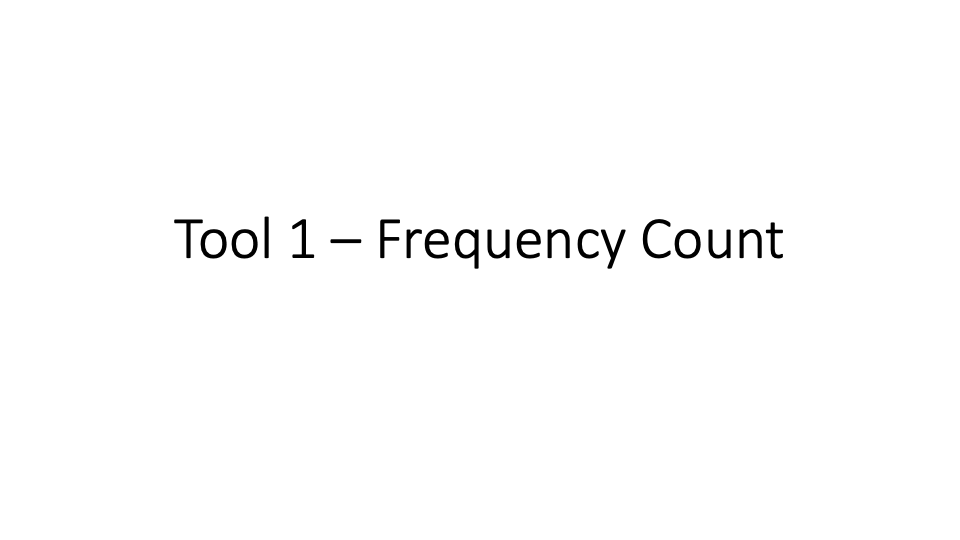

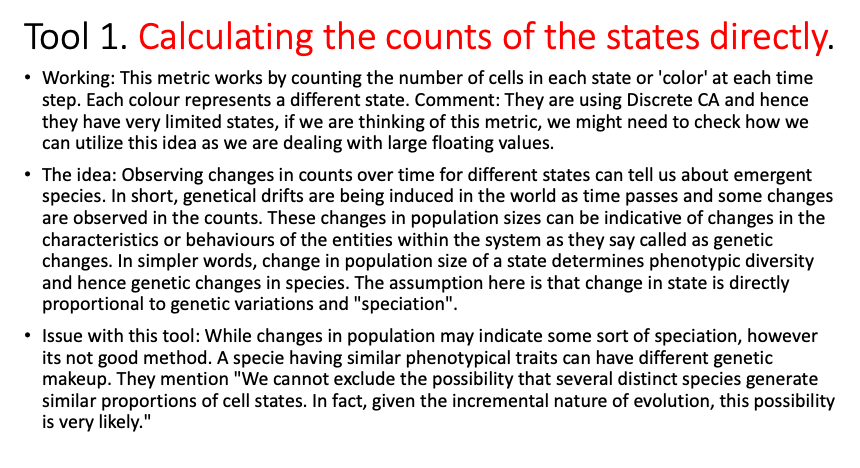

In [ ]:
#@title Convert frequency dicts to desired precision
%%capture

for step, frequency_dict in enumerate(frequency_dicts):
    print(f"Step {step + 1}:")
    for value, count in frequency_dict.items():
        print(f"  Value : {value}, Frequency : {count}")

for step, frequency_dict in enumerate(frequency_dicts):
    print(f"Step {step + 1}:")
    for value, count in list(frequency_dict.items()):
        print("before round off")
        print(f"  Value : {value}, Frequency : {count}")

        # Round off the 'value' to 1 decimal place and update the dictionary
        rounded_value = round(value, 1)
        frequency_dict[rounded_value] = frequency_dict.pop(value)

        print("after round off")
        print(f"  Value : {rounded_value}, Frequency : {count}")
for step, frequency_dict in enumerate(frequency_dicts):
    print(f"Step {step + 1}:")
    for value, count in frequency_dict.items():
        print(f"  Value : {value}, Frequency : {count}")

In [ ]:
#@title Plot the Tool1
import matplotlib.pyplot as plt

# Set a larger figure size
plt.figure(figsize=(10, 6))  # You can adjust the width and height as needed

unique_keys = set()
for frequency_dict in frequency_dicts:
    unique_keys.update(frequency_dict.keys())

# Sort the unique_keys in ascending order
unique_keys = sorted(unique_keys)

x_values = list(range(0, num_steps))
y_values = {key: [] for key in unique_keys}
for step, frequency_dict in enumerate(frequency_dicts):
    for key in unique_keys:
        if key in frequency_dict:
            y_values[key].append(frequency_dict[key])
        else:
            y_values[key].append(0)

for key in unique_keys:
    plt.plot(x_values, y_values[key], label=f'Value {key:.{precision}f}')

plt.xlabel('Step Number')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("tool1_PD.pdf",format='pdf')
plt.show()


In [ ]:
#@title Combined Animation for plotting Tool 1
%%capture
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.figure(figsize=(10, 6))
line, = plt.plot([], [])
plt.xlabel('Step Number')
plt.ylabel('Frequency')
plt.title('Frequency Calculation - Tool 1')
def init():
    line.set_data([], [])
    return line,

def animate(i):
    plt.clf()
    plt.xlabel('Step Number')
    plt.ylabel('Frequency')
    plt.title('Frequency Calculation - Tool 1')

    for key in unique_keys:
        plt.plot(x_values[:i+1], y_values[key][:i+1], label=f'Value {key:.{precision}f}')

    plt.legend(loc='upper right')
    return line,

num_frames = len(x_values)
fps = FPS  # Assuming FPS is frames per second

# Calculate the frame interval in milliseconds
frame_interval = 1000 / fps

animation = FuncAnimation(plt.gcf(), animate, frames=num_frames, init_func=init, blit=True, interval=frame_interval)
animation.save('tool1animation.mp4', writer='ffmpeg')
plt.close()


from IPython.display import HTML
import base64

animation_file_name = 'tool1animation.mp4'
additional_file_name = filename

with open(animation_file_name, "rb") as animation_file:
    animation_bytes = animation_file.read()

with open(additional_file_name, "rb") as additional_file:
    additional_bytes = additional_file.read()

animation_base64 = base64.b64encode(animation_bytes).decode("utf-8")
additional_base64 = base64.b64encode(additional_bytes).decode("utf-8")

video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{animation_base64}" type="video/mp4" width="600"></video>'
additional_file_html = f'<video controls autoplay loop src="data:video/mp4;base64,{additional_base64}" type="video/mp4" width="600"></video>'

combined_html = f'<div style="display: flex; justify-content: center;">{additional_file_html}{video_html}</div>'
# HTML(combined_html)
plt.close()


from moviepy.editor import VideoFileClip, clips_array
import time
animation_file_name = 'tool1animation.mp4'
additional_file_name = filename
animation_clip = VideoFileClip(animation_file_name)
additional_clip = VideoFileClip(additional_file_name)
final_clip = clips_array([[animation_clip, additional_clip]])
temp_file_tool1 = str(int(time.time())) + ".mp4"
final_clip.write_videofile(temp_file_tool1, codec="libx264")
animation_clip.close()
additional_clip.close()
from IPython.display import HTML
import base64

In [ ]:
#@title Display the Tool 1 video and NCA animation

combined_video_file_name = temp_file_tool1
with open(combined_video_file_name, "rb") as video_file:
    video_bytes = video_file.read()
video_base64 = base64.b64encode(video_bytes).decode("utf-8")
video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{video_base64}" type="video/mp4" width="1200"></video>'
HTML(video_html)


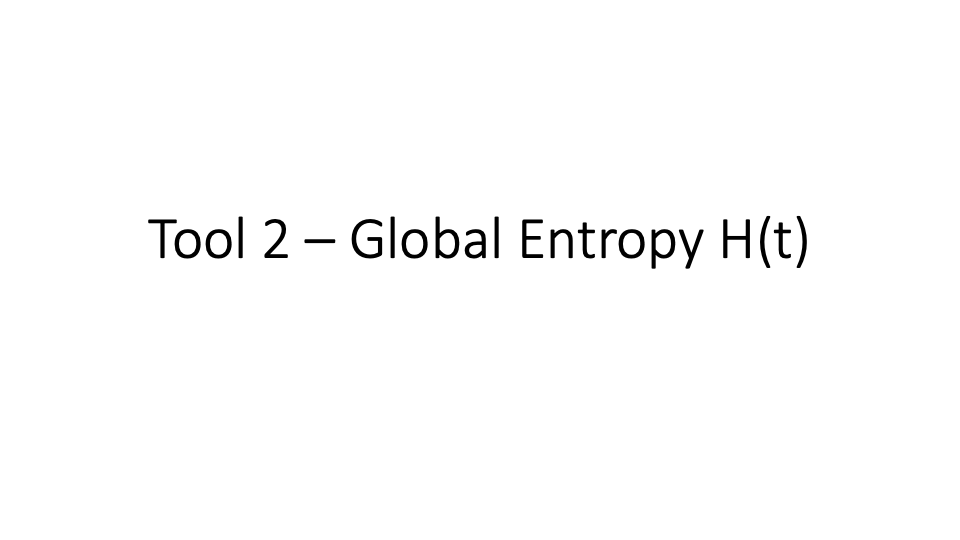

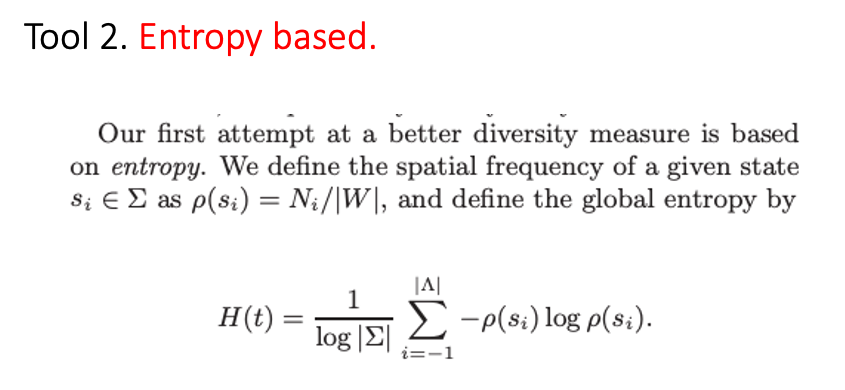

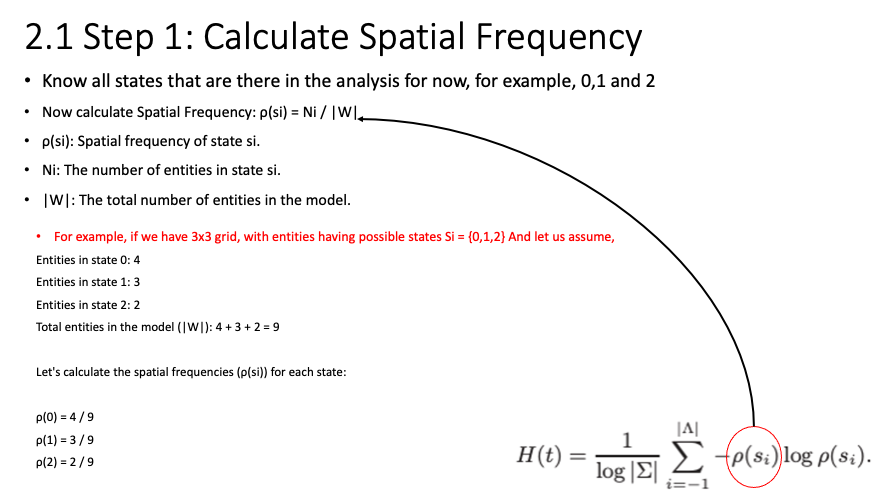

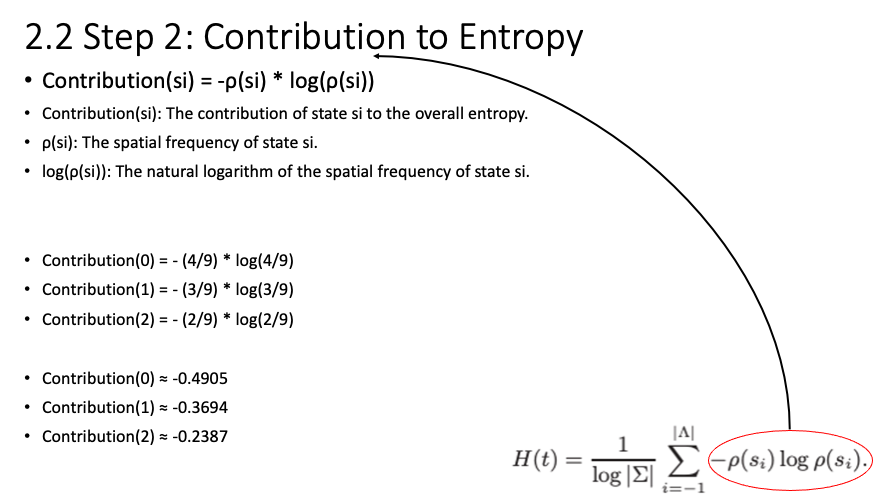

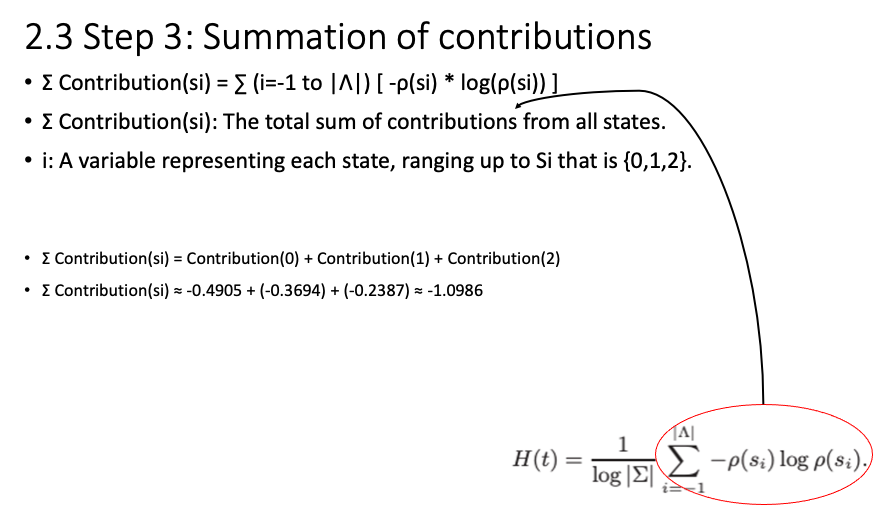

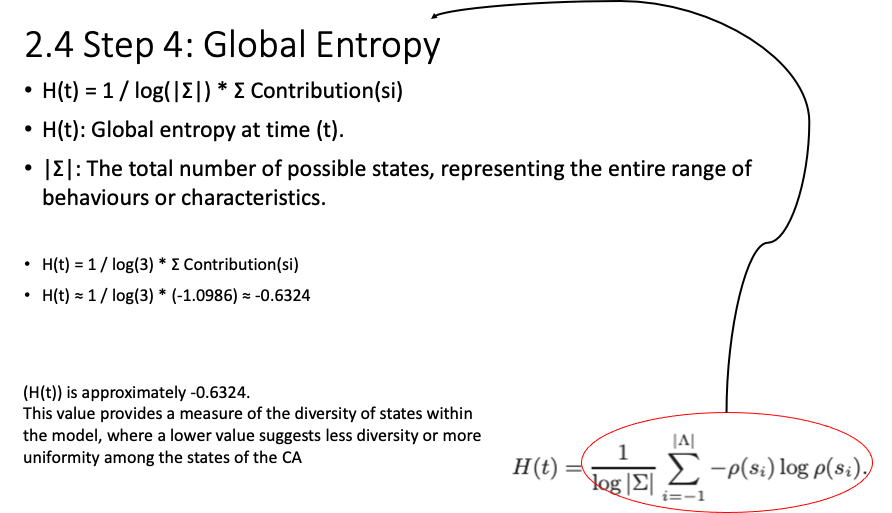

In [ ]:
#@title Processing for Tool2
import math
Global_Entropies_H_ts = []
for step, frequency_dict in enumerate(frequency_dicts):
  total_count_W = 0
  ρ = []
  contributions = []
  Σ = 0
  H_t = 0
  total_states = 0
  for value, count in frequency_dict.items():
    if(value==0):
      total_states = 1
    else:
      total_states = total_states + 1
  for value, count in frequency_dict.items():
    total_count_W = total_count_W + count
  for value, count in frequency_dict.items():
    ρ.append(count/total_count_W)
  for each_ρ in ρ:
    contributions.append((-each_ρ) * math.log(each_ρ))
  for each in contributions:
    Σ = Σ + each
  if(math.log(total_states) == 0):
    H_t = Σ
  else:
    H_t = (1/math.log(total_states)) * Σ
  Global_Entropies_H_ts.append(H_t)


In [ ]:
#@title Plot Global Entropy
import matplotlib.pyplot as plt
Global_Entropies_H_ts = Global_Entropies_H_ts
steps = list(range(len(Global_Entropies_H_ts)))
plt.plot(steps, Global_Entropies_H_ts, marker='o', markersize=marker_size, linestyle='-')
plt.xlabel('Step')
plt.ylabel('Entropy (H_t)')
plt.title('Global Entropies over Steps')
plt.grid(True)
plt.savefig("tool2_PD.pdf",format='pdf')
plt.show()


In [ ]:
#@title Combined Animation for plotting Tool 2
%%capture
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
Global_Entropies_H_ts = Global_Entropies_H_ts
steps = list(range(len(Global_Entropies_H_ts)))
fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Entropy (H_t)')
ax.set_title('Global Entropies over Steps - Tool 2')
ax.grid(True)
def update(frame):
    ax.clear()
    ax.plot(steps[:frame+1], Global_Entropies_H_ts[:frame+1], marker='o', markersize=marker_size, linestyle='-')
    ax.set_xlabel('Step')
    ax.set_ylabel('Entropy (H_t)')
    ax.set_title('Global Entropies over Steps - Tool 2')
    ax.grid(True)
ani = FuncAnimation(fig, update, frames=len(steps), repeat=False)
ani.save("tool2animation.mp4", writer="ffmpeg", fps=FPS)
# HTML(ani.to_jshtml())
plt.close()


from IPython.display import HTML
import base64

animation_file_name = 'tool2animation.mp4'
additional_file_name = filename

with open(animation_file_name, "rb") as animation_file:
    animation_bytes = animation_file.read()

with open(additional_file_name, "rb") as additional_file:
    additional_bytes = additional_file.read()

animation_base64 = base64.b64encode(animation_bytes).decode("utf-8")
additional_base64 = base64.b64encode(additional_bytes).decode("utf-8")

video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{animation_base64}" type="video/mp4" width="600"></video>'
additional_file_html = f'<video controls autoplay loop src="data:video/mp4;base64,{additional_base64}" type="video/mp4" width="600"></video>'

combined_html = f'<div style="display: flex; justify-content: center;">{additional_file_html}{video_html}</div>'
# HTML(combined_html)
plt.close()


from moviepy.editor import VideoFileClip, clips_array
import time
animation_file_name = 'tool2animation.mp4'
additional_file_name = filename
animation_clip = VideoFileClip(animation_file_name)
additional_clip = VideoFileClip(additional_file_name)
final_clip = clips_array([[animation_clip, additional_clip]])
temp_file_tool2 = str(int(time.time())) + ".mp4"
final_clip.write_videofile(temp_file_tool2, codec="libx264")
animation_clip.close()
additional_clip.close()
from IPython.display import HTML
import base64

In [ ]:
#@title Display the Tool 2 video and NCA animation

combined_video_file_name = temp_file_tool2
with open(combined_video_file_name, "rb") as video_file:
    video_bytes = video_file.read()
video_base64 = base64.b64encode(video_bytes).decode("utf-8")
video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{video_base64}" type="video/mp4" width="1200"></video>'
HTML(video_html)


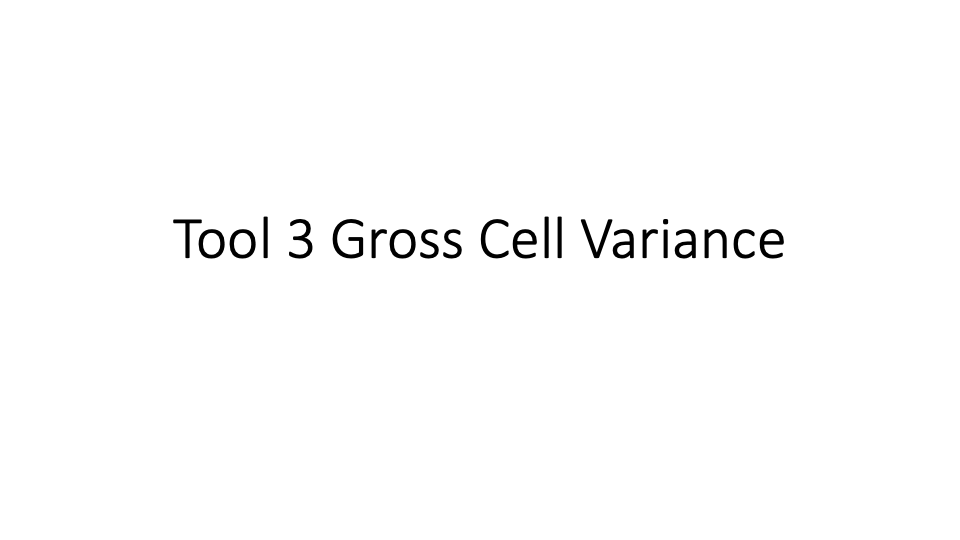

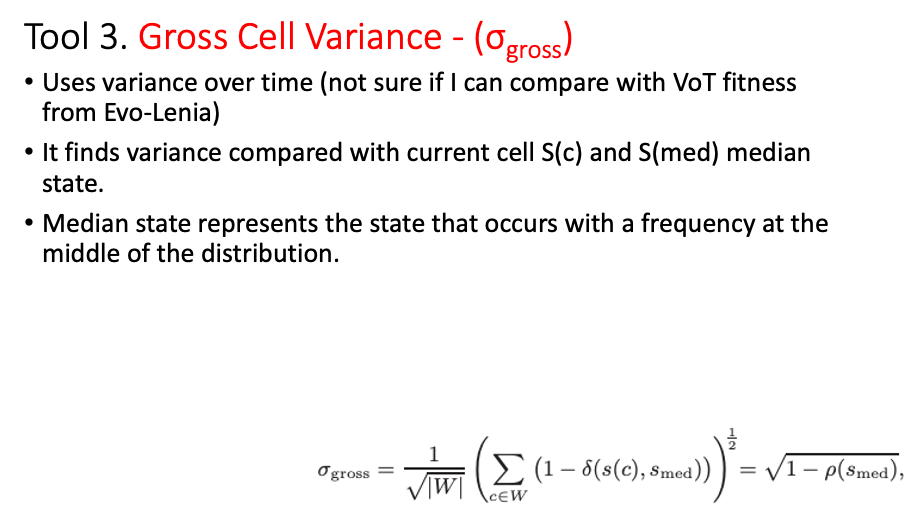

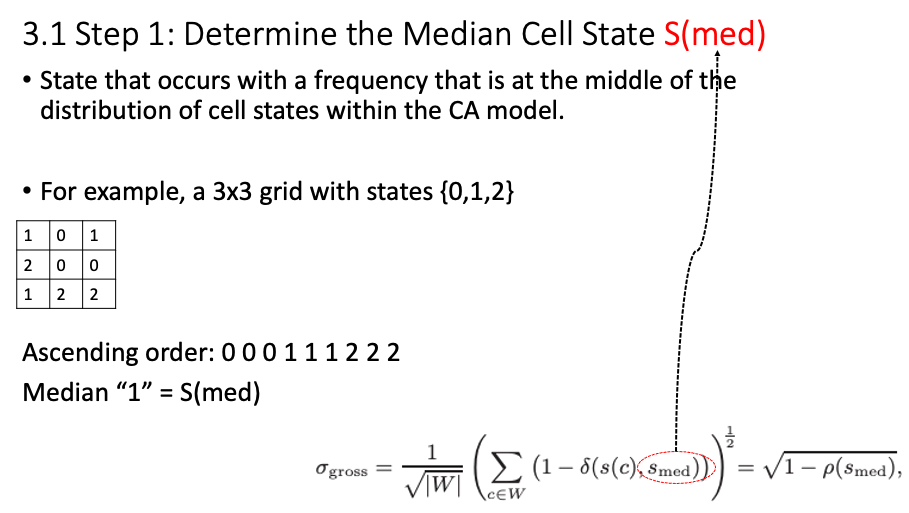

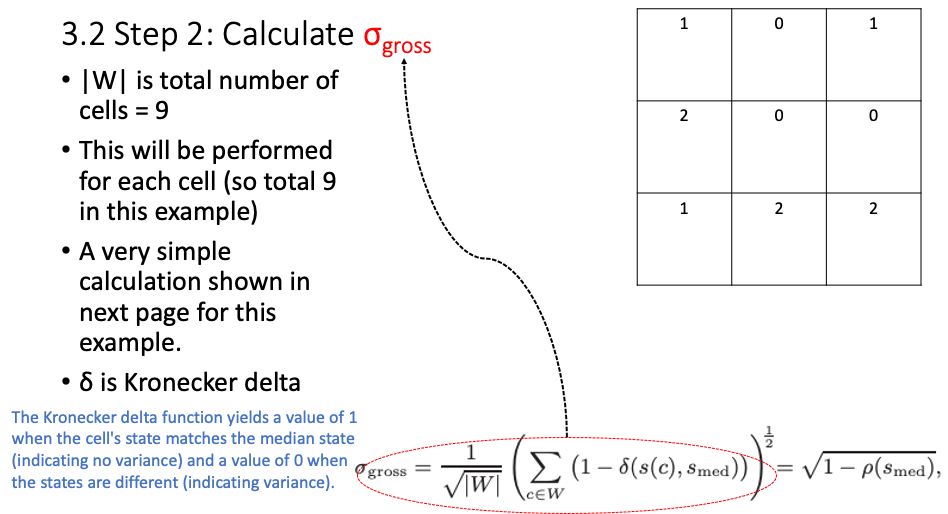

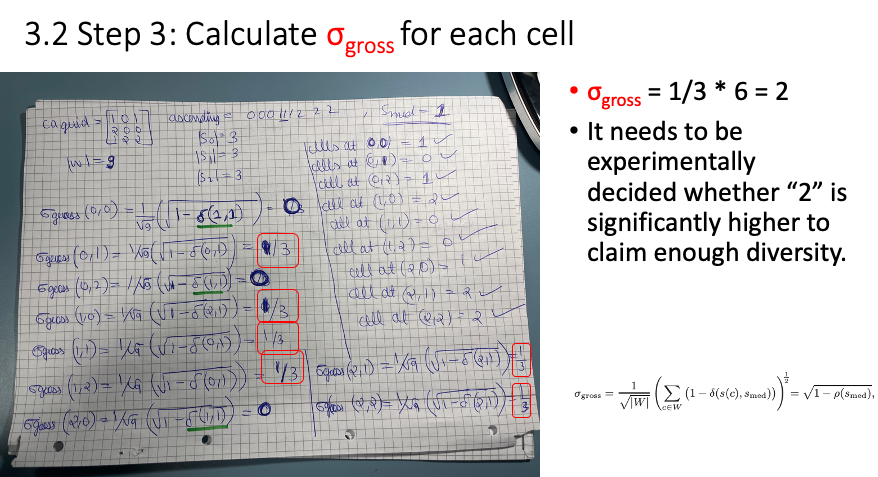

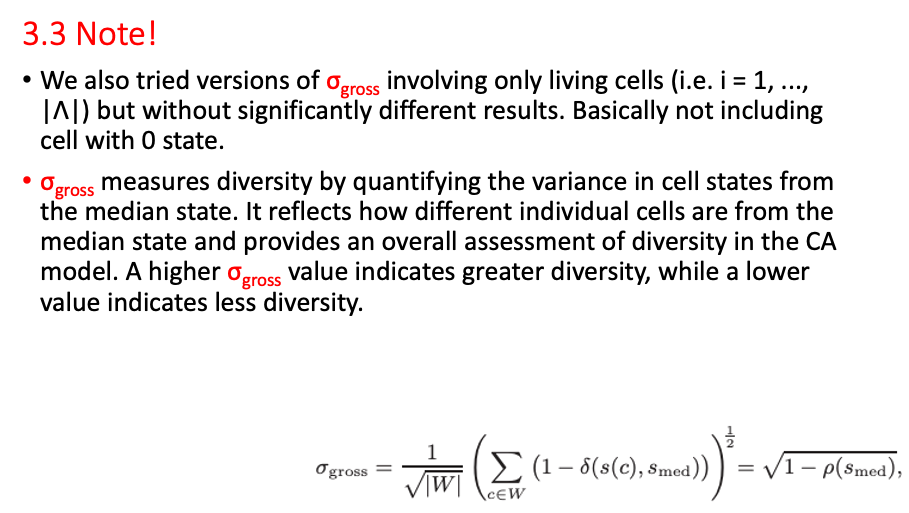

In [ ]:
#@title Calculate median at every step

# Comment line belwo if you want to print outputs
%%capture
medians = []
for step, frequency_dict in enumerate(frequency_dicts):
    print(f"Step {step + 1}:")
    values_with_repetitions = []
    for value, count in frequency_dict.items():
        values_with_repetitions.extend([value] * count)
    values_with_repetitions.sort()
    n = len(values_with_repetitions)
    if n % 2 == 0:
        median = (values_with_repetitions[n // 2 - 1] + values_with_repetitions[n // 2]) / 2
    else:
        median = values_with_repetitions[n // 2]
    medians.append(median)
    print(f"  Median: {median:.{precision}f}")


def round_list_elements(input_list, precision):
    rounded_list = [round(element, precision) for element in input_list]
    return rounded_list
medians = round_list_elements(medians, precision)

In [ ]:
#@title Calculate Gross Cell Variance
total_count_W = 0
for value, count in frequency_dict.items():
  total_count_W = total_count_W + count # Which is also equal to width * height


def kroncker_delta(x,y):
  if(x==y):
    return 1
  else:
    return 0
import math
ca_grids = ca_grids_for_later_analysis
gross_cell_variance = []
for y in range(len(ca_grids)): # total number_of_steps number of grids are there
  σ_gross = 0
  ca_grids_temp = ca_grids[y].flatten()
  for z in range(len(ca_grids_temp)):
    # print(round(ca_grids_temp[z],precision))
    δ = kroncker_delta(round(ca_grids_temp[z],precision),medians[y])
    σ_gross = σ_gross + (1-δ)
  gross_cell_variance.append(1/math.sqrt(total_count_W) * math.sqrt(σ_gross))

In [ ]:
#@title Plot Gross Cell Variance
import matplotlib.pyplot as plt
gross_cell_variance = gross_cell_variance
steps = list(range(len(gross_cell_variance)))
plt.plot(steps, gross_cell_variance, marker='o', markersize=marker_size, linestyle='-')
plt.xlabel('Step')
plt.ylabel('Variance (σ_gross)')
plt.title('σ gross over Steps')
plt.grid(True)
plt.savefig("tool3_PD.pdf",format='pdf')
plt.show()


In [ ]:
#@title Combined Animation for plotting Tool 3
%%capture
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
gross_cell_variance = gross_cell_variance
steps = list(range(len(gross_cell_variance)))
fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Variance (σ_gross)')
ax.set_title('σ gross over Steps - Tool 3')
ax.grid(True)
def update(frame):
    ax.clear()
    ax.plot(steps[:frame+1], gross_cell_variance[:frame+1], marker='o', markersize=marker_size, linestyle='-')
    ax.set_xlabel('Step')
    ax.set_ylabel('Variance (σ_gross)')
    ax.set_title('σ gross over Steps - Tool 3')
    ax.grid(True)
ani = FuncAnimation(fig, update, frames=len(steps), repeat=False)
ani.save("tool3animation.mp4", writer="ffmpeg", fps=FPS)
# HTML(ani.to_jshtml())
plt.close()


from IPython.display import HTML
import base64

animation_file_name = 'tool3animation.mp4'
additional_file_name = filename

with open(animation_file_name, "rb") as animation_file:
    animation_bytes = animation_file.read()

with open(additional_file_name, "rb") as additional_file:
    additional_bytes = additional_file.read()

animation_base64 = base64.b64encode(animation_bytes).decode("utf-8")
additional_base64 = base64.b64encode(additional_bytes).decode("utf-8")

video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{animation_base64}" type="video/mp4" width="600"></video>'
additional_file_html = f'<video controls autoplay loop src="data:video/mp4;base64,{additional_base64}" type="video/mp4" width="600"></video>'

combined_html = f'<div style="display: flex; justify-content: center;">{additional_file_html}{video_html}</div>'
# HTML(combined_html)
plt.close()


from moviepy.editor import VideoFileClip, clips_array
import time
animation_file_name = 'tool3animation.mp4'
additional_file_name = filename
animation_clip = VideoFileClip(animation_file_name)
additional_clip = VideoFileClip(additional_file_name)
final_clip = clips_array([[animation_clip, additional_clip]])
temp_file_tool3 = str(int(time.time())) + ".mp4"
final_clip.write_videofile(temp_file_tool3, codec="libx264")
animation_clip.close()
additional_clip.close()
from IPython.display import HTML
import base64

In [ ]:
#@title Display the Tool 3 video and NCA animation

combined_video_file_name = temp_file_tool3
with open(combined_video_file_name, "rb") as video_file:
    video_bytes = video_file.read()
video_base64 = base64.b64encode(video_bytes).decode("utf-8")
video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{video_base64}" type="video/mp4" width="1200"></video>'
HTML(video_html)


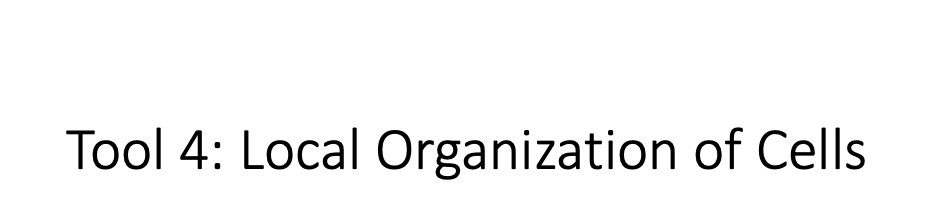

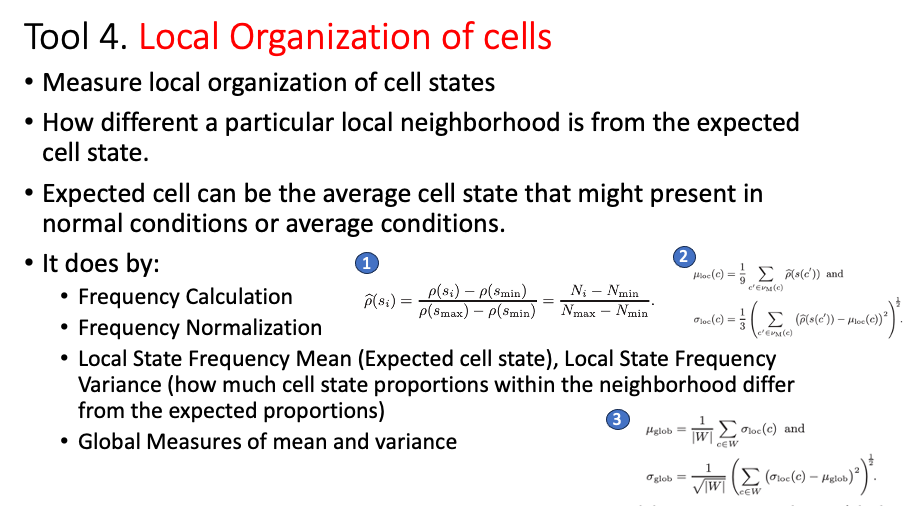

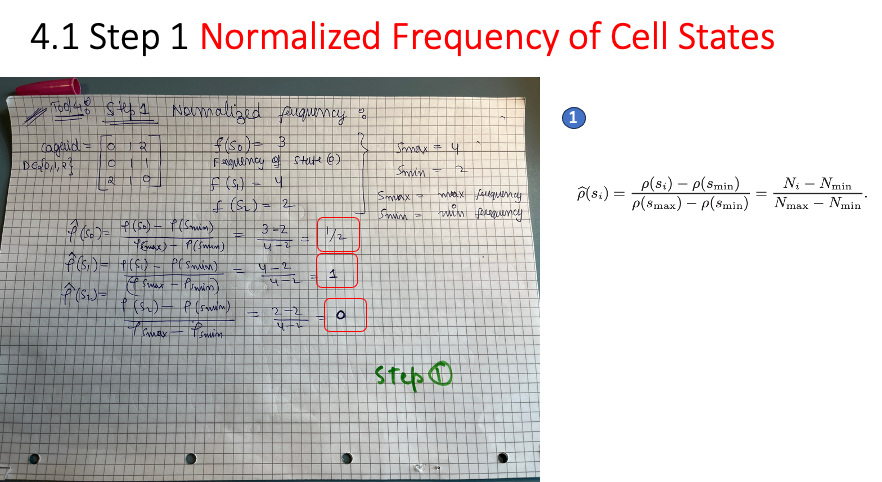

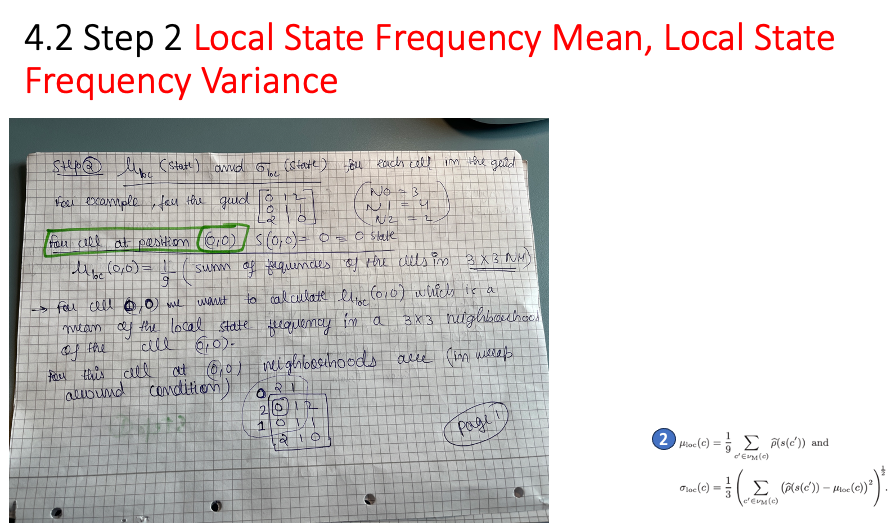

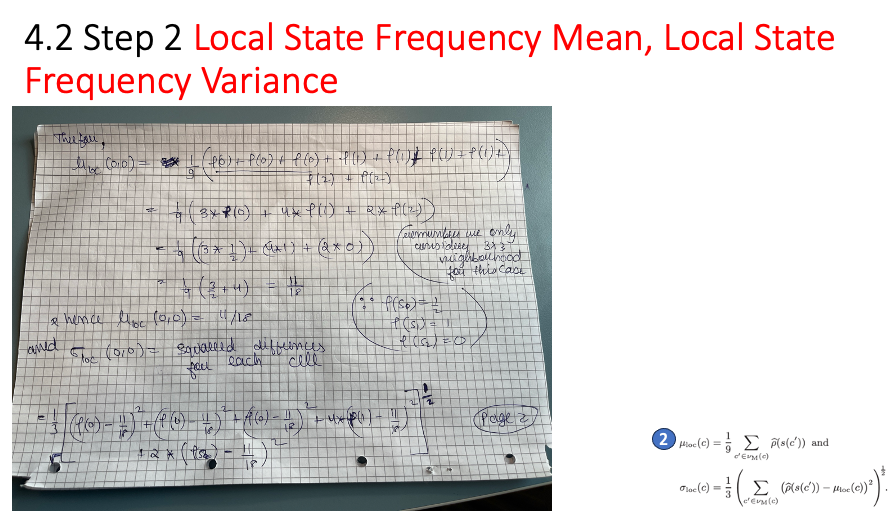

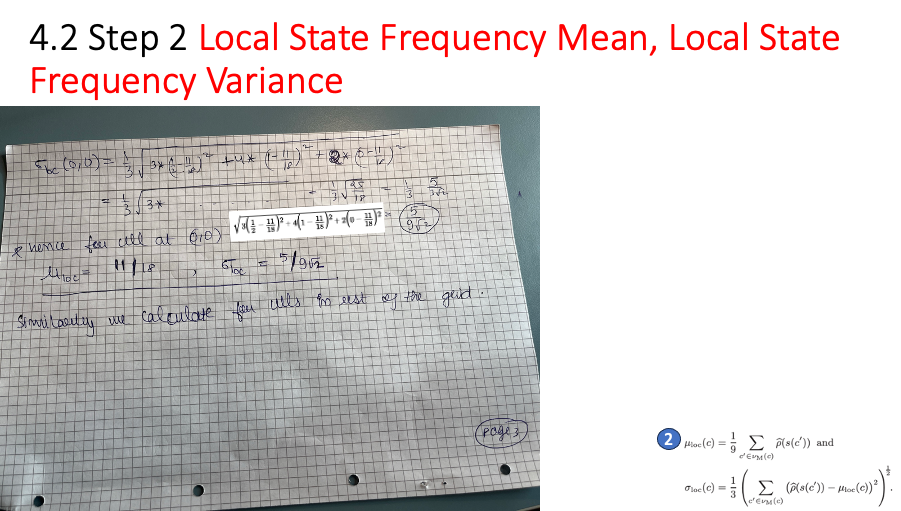

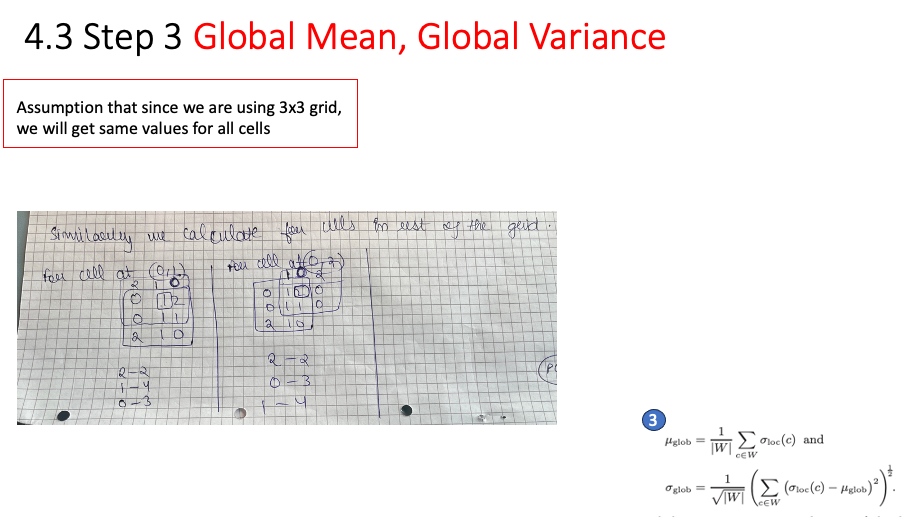

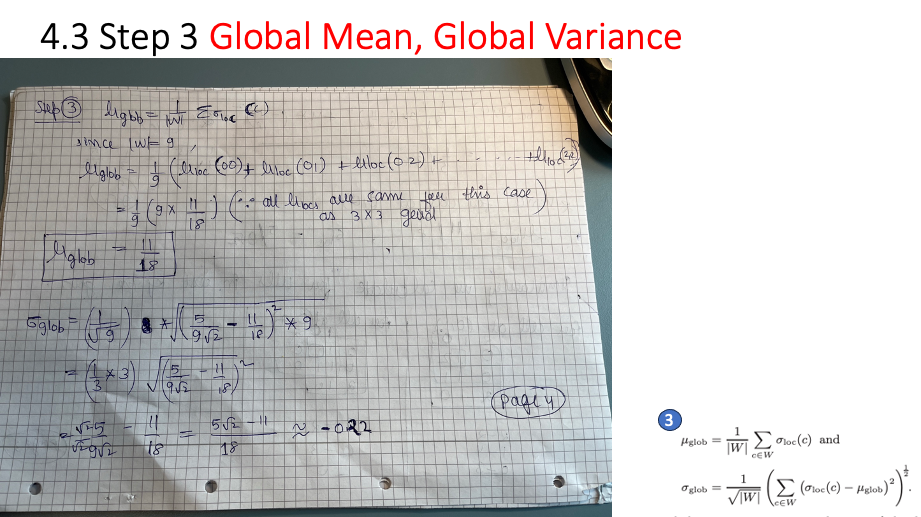

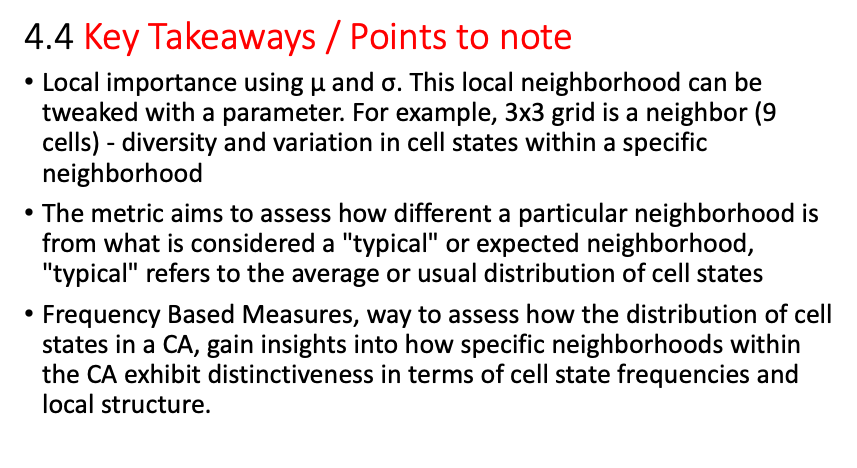

In [ ]:
#@title Normalized Frequencies
%%capture
ca_grids = ca_grids_for_later_analysis
for each_grid in ca_grids:
  width = each_grid.shape[0]
  height = each_grid.shape[1]
  for i in range(width):
    for j in range(height):
      cell_value = each_grid[i][j]
      # print("value before",cell_value)
      updated = round(cell_value,precision)
      each_grid[i][j] = updated
      # print("value after",updated)

print(ca_grids)

def round_dict_keys(input_dict, precision):
    rounded_dict = {}
    for key, value in input_dict.items():
        rounded_key = round(key, precision)
        rounded_dict[rounded_key] = value
    return rounded_dict

normalized_frequency_dicts = []
for step, frequency_dict in enumerate(frequency_dicts):
    min_count = min(frequency_dict.values())
    max_count = max(frequency_dict.values())
    normalized_frequency_dict = {}
    for value, count in frequency_dict.items():
        if(min_count == max_count):
          normalized_count = 0
          normalized_frequency_dict[value] = normalized_count
        else:
          normalized_count = (count - min_count) / (max_count - min_count)
          normalized_frequency_dict[value] = normalized_count
    normalized_frequency_dicts.append(round_dict_keys(normalized_frequency_dict,precision))
for step, normalized_frequency_dict in enumerate(normalized_frequency_dicts):
    print(f"Step {step + 1}:")
    for value, normalized_count in normalized_frequency_dict.items():
        print(f"  Value {value:}: Normalized Frequency {normalized_count}")



In [ ]:
#@title Calculate mu locations for the ca_grid - Local State Frequency Mean
def get_neighbors_with_wrap_around(grid, row, col, window_size, grid_size):
    neighbors = []
    for i in range(-window_size, window_size + 1):
        for j in range(-window_size, window_size + 1):
            new_row, new_col = (row + i) % grid_size, (col + j) % grid_size
            neighbors.append(grid[new_row][new_col])
    return neighbors

window_size = 1

def frequency_of(key, my_dict):
    # print("key as input", key)
    key = round(key,precision)
    key = min(my_dict, key=lambda x: abs(x - key))
    # print("key after precision", key)
    if key in my_dict:
        return my_dict[key]
    else:
        return None
import copy
mu_loc_data = []
for each_grid,frequency_dict_temp in zip(ca_grids,normalized_frequency_dicts):
  # frequency_dict_temp = round_dict_keys(frequency_dict_temp,precision)
  width = each_grid.shape[0]
  height = each_grid.shape[1]
  grid_size = each_grid.shape[0]
  rows = width # Replace 'rows' with the number of rows you want
  cols = height  # Replace 'cols' with the number of columns you want
  mu_locs_list_2d = []
  for i in range(rows):
      mu_locs_list_2d.append([None] * cols)
  for i in range(width):
    for j in range(height):
      current_cell = each_grid[i][j]
      current_cell_index_row = i
      current_cell_index_column = j
      # print(each_grid)
      neighbors_of_current_cell = get_neighbors_with_wrap_around(each_grid,current_cell_index_row,current_cell_index_column,window_size,grid_size)
      # print("neighbors",neighbors_of_current_cell)
      sum_of_frequencies_of_cell = 0
      for each_neighbor in neighbors_of_current_cell:
        # print("pciked neighbor",each_neighbor)
        # print("frequency dict",frequency_dict_temp)
        sum_of_frequencies_of_cell = sum_of_frequencies_of_cell + frequency_of(each_neighbor,frequency_dict_temp)
      mu_loc_current_cell = sum_of_frequencies_of_cell/9
      mu_locs_list_2d[i][j] = mu_loc_current_cell
  mu_loc_data.append(mu_locs_list_2d)

In [ ]:
#@title Calculate sigma locations for the ca_grid - Local State Frequency Variance

def get_neighbors_with_wrap_around(grid, row, col, window_size, grid_size):
    neighbors = []
    for i in range(-window_size, window_size + 1):
        for j in range(-window_size, window_size + 1):
            new_row, new_col = (row + i) % grid_size, (col + j) % grid_size
            neighbors.append(grid[new_row][new_col])
    return neighbors

window_size = 1

def frequency_of(key, my_dict):
    # print("key as input", key)
    key = round(key,precision)
    key = min(my_dict, key=lambda x: abs(x - key))
    # print("key after precision", key)
    if key in my_dict:
        return my_dict[key]
    else:
        return None
import copy
import math
sigma_loc_data = []
for each_grid,frequency_dict_temp,mu_data in zip(ca_grids,normalized_frequency_dicts,mu_loc_data):
  # frequency_dict_temp = round_dict_keys(frequency_dict_temp,precision)
  width = each_grid.shape[0]
  height = each_grid.shape[1]
  grid_size = each_grid.shape[0]
  rows = width
  cols = height
  sigma_locs_list_2d = []
  for i in range(rows):
      sigma_locs_list_2d.append([None] * cols)
  for i in range(width):
    for j in range(height):
      current_cell = each_grid[i][j]
      current_cell_index_row = i
      current_cell_index_column = j
      neighbors_of_current_cell = get_neighbors_with_wrap_around(each_grid,current_cell_index_row,current_cell_index_column,window_size,grid_size)
      sum_of_squared_frequencies = 0
      for each_neighbor in neighbors_of_current_cell:
        difference = frequency_of(each_neighbor,frequency_dict_temp) - mu_data[i][j]
        squared = difference ** 2
        sum_of_squared_frequencies = sum_of_squared_frequencies + squared
      sigma_loc_current_cell = math.sqrt(sum_of_squared_frequencies)/3
      sigma_locs_list_2d[i][j] = sigma_loc_current_cell
  sigma_loc_data.append(sigma_locs_list_2d)

In [ ]:
#@title Global mean and global variance
mu_global = []
for a in range(len(ca_grids)):
  mu_g = 0
  W = ca_grids[a].shape[0] * ca_grids[a].shape[1]
  for x in range(ca_grids[a].shape[0]):
    for y in range(ca_grids[a].shape[1]):
      mu_g = mu_g + sigma_loc_data[a][x][y]
  mu_g = mu_g/W
  mu_global.append(mu_g)

# print(mu_global)

sigma_global = []
for a in range(len(ca_grids)):
  mu_glob = mu_global[a]
  sigma_sum = 0
  W = ca_grids[a].shape[0] * ca_grids[a].shape[1]
  for x in range(ca_grids[a].shape[0]):
    for y in range(ca_grids[a].shape[1]):
      sigma_sum = sigma_sum + (sigma_loc_data[a][x][y] - mu_glob)**2
  sigma_root = math.sqrt(sigma_sum)
  sigma_globa = sigma_root/math.sqrt(W)
  sigma_global.append(sigma_globa)
# print(sigma_global)

In [ ]:
#@title Plot Global Variance using Local Organzation of Cells
import matplotlib.pyplot as plt
sigma_global = sigma_global
steps = list(range(len(sigma_global)))
plt.plot(steps, sigma_global, marker='o', markersize=marker_size, linestyle='-')
plt.xlabel('Step')
plt.ylabel('Variance (σ_global)')
plt.title('σ global over Steps using Local Organzation of Cells')
plt.grid(True)
plt.savefig("tool4_PD.pdf",format='pdf')
plt.show()


In [ ]:
#@title Combined Animation for plotting Tool 4
%%capture
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
sigma_global = sigma_global
steps = list(range(len(sigma_global)))
fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Variance (σ_global)')
ax.set_title('σ global over Steps using Local Organzation of Cells')
ax.grid(True)
def update(frame):
    ax.clear()
    ax.plot(steps[:frame+1], sigma_global[:frame+1], marker='o', markersize=marker_size, linestyle='-')
    ax.set_xlabel('Step')
    ax.set_ylabel('Variance (σ_global)')
    ax.set_title('σ global over Steps using Local Organzation of Cells')
    ax.grid(True)
ani = FuncAnimation(fig, update, frames=len(steps), repeat=False)
ani.save("tool4animation.mp4", writer="ffmpeg", fps=FPS)
# HTML(ani.to_jshtml())
plt.close()


from IPython.display import HTML
import base64

animation_file_name = 'tool4animation.mp4'
additional_file_name = filename

with open(animation_file_name, "rb") as animation_file:
    animation_bytes = animation_file.read()

with open(additional_file_name, "rb") as additional_file:
    additional_bytes = additional_file.read()

animation_base64 = base64.b64encode(animation_bytes).decode("utf-8")
additional_base64 = base64.b64encode(additional_bytes).decode("utf-8")

video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{animation_base64}" type="video/mp4" width="600"></video>'
additional_file_html = f'<video controls autoplay loop src="data:video/mp4;base64,{additional_base64}" type="video/mp4" width="600"></video>'

combined_html = f'<div style="display: flex; justify-content: center;">{additional_file_html}{video_html}</div>'
# HTML(combined_html)
plt.close()


from moviepy.editor import VideoFileClip, clips_array
import time
animation_file_name = 'tool4animation.mp4'
additional_file_name = filename
animation_clip = VideoFileClip(animation_file_name)
additional_clip = VideoFileClip(additional_file_name)
final_clip = clips_array([[animation_clip, additional_clip]])
temp_file_tool4 = str(int(time.time())) + ".mp4"
final_clip.write_videofile(temp_file_tool4, codec="libx264")
animation_clip.close()
additional_clip.close()
from IPython.display import HTML
import base64

In [ ]:
#@title Display the Tool 4 video and NCA animation

combined_video_file_name = temp_file_tool4
with open(combined_video_file_name, "rb") as video_file:
    video_bytes = video_file.read()
video_base64 = base64.b64encode(video_bytes).decode("utf-8")
video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{video_base64}" type="video/mp4" width="1200"></video>'
HTML(video_html)


In [ ]:
#@title Display Tool 1, Tool 2, Tool 3 and Tool 4
%%capture
animation_video = filename
tool1video = 'tool1animation.mp4'
tool2video = 'tool2animation.mp4'
tool3video = 'tool3animation.mp4'
tool4video = 'tool4animation.mp4'

animation_clip = VideoFileClip(animation_video)
additional_clip1 = VideoFileClip(tool1video)
additional_clip2 = VideoFileClip(tool2video)
additional_clip3 = VideoFileClip(tool3video)
additional_clip4 = VideoFileClip(tool4video)

final_clip = clips_array([[animation_clip, additional_clip1, additional_clip2, additional_clip3, additional_clip4]])
fiveplots = "five_plots_"+str(int(time.time())) + ".mp4"
final_clip.write_videofile(fiveplots, codec="libx264")
animation_clip.close()
additional_clip.close()
from IPython.display import HTML
import base64

In [ ]:
#@title Display the All tools video and NCA animation

combined_video_file_name = fiveplots
with open(combined_video_file_name, "rb") as video_file:
    video_bytes = video_file.read()
video_base64 = base64.b64encode(video_bytes).decode("utf-8")
video_html = f'<video controls autoplay loop src="data:video/mp4;base64,{video_base64}" type="video/mp4" width="2500"></video>'
HTML(video_html)

In [ ]:
#@title Show Tools 2, 3 and 4 in single plot.
import matplotlib.pyplot as plt
plot_data_tool2 = Global_Entropies_H_ts
plot_data_tool3 = gross_cell_variance
plot_data_tool4 = sigma_global
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(plot_data_tool2, marker='o', markersize=marker_size, label='H$_t$') #  for Tool 2
ax.plot(plot_data_tool3, marker='s', markersize=marker_size, label='σ$_{gross}$') # for Tool 3
ax.plot(plot_data_tool4, marker='^', markersize=marker_size, label='σ$_{glob}$') # for Tool 4


ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('All Tool Information in a Single Plot')

ax.legend()

plt.grid(True)
plt.savefig("tool234_PD.pdf",format='pdf')
plt.show()


# Tools for Genotypic Diversity

In [ ]:
%%capture
#@title Tool 1 RWSP from SIM paper, Display three random weights in RGB channels
import numpy as np
import random
import math
import matplotlib.pyplot as plt
number_of_random_weights = 3

import math
this_list_should_contain_NN_for_every_step = everystep_weights
def round_elements_in_nested_list(input_list, precision=2):
    if isinstance(input_list, list):
        return [round_elements_in_nested_list(elem, precision) for elem in input_list]
    else:
        return round(input_list, precision)

rounded_list = round_elements_in_nested_list(this_list_should_contain_NN_for_every_step, precision)
rounded_list_further = rounded_list
round_list_array = np.array(rounded_list_further)
steps_value = round_list_array.shape[0]
row_col = round_list_array.shape[1]
params = round_list_array.shape[2]
rounded_genes_final = round_list_array.reshape(steps_value,int(math.sqrt(row_col)),int(math.sqrt(row_col)),params)

rounded_array_further = np.zeros((steps_value,int(math.sqrt(row_col)),int(math.sqrt(row_col)),number_of_random_weights))
random_postions = random.sample(range(params), number_of_random_weights)
for i in range(steps_value):
    for j in range(int(math.sqrt(row_col))):
        for k in range(int(math.sqrt(row_col))):
            selected_values_array = rounded_genes_final[i][j][k]
            selected_values = np.array([selected_values_array[i] for i in random_postions])
            rounded_array_further[i][j][k] = selected_values
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

data = rounded_array_further
normalized_data = (data * 255).astype(np.uint8)

length = len(normalized_data)
def update(frame):
    plt.clf()
    plt.imshow(normalized_data[frame])
    plt.title(f'Time Step {frame+1}')
    if(frame == length-1):
      plt.savefig("tool1_GD_RWSP.pdf",format='pdf')

fig, ax = plt.subplots()
animation = FuncAnimation(fig, update, frames=len(normalized_data), interval=200, repeat=False)
tool1_file = "tool1_gd_animation.mp4"
animation.save(tool1_file, writer='ffmpeg', fps=1)



In [ ]:
#@title Display Tool 1 GD Video
import base64
from IPython.display import HTML

# Load the animation MP4 file
with open('tool1_gd_animation.mp4', 'rb') as file:
    animation_data = file.read()

# Convert the animation data to base64
animation_base64 = base64.b64encode(animation_data).decode('utf-8')

# Create an HTML element to display the animation
html_code = f'<video controls><source type="video/mp4" src="data:video/mp4;base64,{animation_base64}"></video>'
HTML(html_code)


In [ ]:
%%capture
#@title Tool 2 (Bar Plot) track the behaviour of NN over time using Clustering approach

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from PIL import Image

k = KMEANS_K  # Set smaller value for smaller runs
this_list_should_contain_NN_for_every_step = everystep_weights
list_of_weights_at_every_step = round_elements_in_nested_list(this_list_should_contain_NN_for_every_step)
marker_size = marker_size  # Add marker size definition

# Initialize colors for clusters based on initial assignment
initial_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# Initialize centroids only once based on the first frame
initial_frame_weights = list_of_weights_at_every_step[0]
initial_centroids = KMeans(n_clusters=k, random_state=0, n_init=1).fit(
    StandardScaler().fit_transform(initial_frame_weights)).cluster_centers_

# Dictionary to store cluster colors based on initial assignment
cluster_colors = {cluster_id: initial_colors[cluster_id] for cluster_id in range(k)}

# Store centroid data for each step
centroid_data = []
cluster_data = []  # Modified: Initialize cluster_data list to store cluster counts for each step
for i in range(len(list_of_weights_at_every_step)):
    weight_parameters = list_of_weights_at_every_step[i]
    normalized_data = StandardScaler().fit_transform(weight_parameters)

    # Use the initial centroids for k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1, init=initial_centroids)
    kmeans.fit(normalized_data)
    clusters = kmeans.predict(normalized_data)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(normalized_data)

    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the cluster points on the left subplot
    for cluster_id in range(k):
        cluster_points = reduced_data[clusters == cluster_id]
        axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], s=marker_size, label=f'Cluster {cluster_id}',
                       c=cluster_colors[cluster_id])

    # Highlight the centroids with larger markers
    axs[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=2 * marker_size, marker='X',
                   c='black', label='Centroids')
    axs[0].set_title(f'K-Means Clustering (k={k})')

    # Plot the count of points for each cluster on the right subplot
    cluster_counts = np.bincount(clusters, minlength=k)  # Ensure that the cluster counts have length k
    cluster_data.append(cluster_counts)

    bar_container = axs[1].bar(list(range(k)), cluster_counts, color=[cluster_colors[cluster_id] for cluster_id in range(k)])
    axs[1].set_title('Cluster Point Counts')

    # Add labels on top of each bar
    for rect, value in zip(bar_container, cluster_counts):
        height = rect.get_height()
        axs[1].text(rect.get_x() + rect.get_width() / 2, height, f'{value}', ha='center', va='bottom')

    # Save the combined plot
    frames_folder = "TOOL2_GD_FRAMES_CLUSTERING"
    if not os.path.exists(frames_folder):
        os.makedirs(frames_folder)
    filename = os.path.join(frames_folder, '{:07d}.png'.format(i))
    plt.savefig(filename, format='png', dpi=500)
    filename = os.path.join(frames_folder, '{:07d}.pdf'.format(i))
    plt.savefig(filename, format='pdf', dpi=500)
    plt.close()

    # Save centroid data for each step
    centroid_data.append(kmeans.cluster_centers_)

# Display the combined clustering plot
frames_folder = "TOOL2_GD_FRAMES_CLUSTERING"
frame_files = [f for f in os.listdir(frames_folder) if f.endswith(".png")]
frame_files.sort(key=lambda x: int(x.split(".")[0]))
frames = []
for frame_file in frame_files:
    frame_path = os.path.join(frames_folder, frame_file)
    frame = Image.open(frame_path)
    frames.append(frame)

# Define GIF-related parameters
output_gif_path = "tool2_clustering_animation.gif"
desired_fps = FPS  # Add FPS definition
duration = int(1000 / desired_fps)

# Save frames as an animated GIF
frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=duration,
    loop=0,
    disposal=2,
    optimize=False
)


In [ ]:
#@title Display Tool 2 Clustering Approach
# Specify the desired width (e.g., 500 pixels)
desired_width = 1200
with open(output_gif_path, "rb") as gif_file:
    gif_base64 = base64.b64encode(gif_file.read()).decode()
# Display the combined clustering plot with a specific width
HTML(f'<img src="data:image/gif;base64,{gif_base64}" width="{desired_width}">')


In [ ]:
#@title Tool 2 Plot 1
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = cluster_data
data = np.array(data)
# Number of species and number of steps
n = data.shape[0] # Number of steps
k = data.shape[1] # Number of species


# Generate random data for k species and n steps
data = data.flatten()
species_labels = [f'Species {i}' for i in range(1, k + 1) for _ in range(n)]

# Create a DataFrame for Seaborn
data_df = pd.DataFrame({'Value': data, 'Species': species_labels})

# Create a KDE plot using Seaborn
sns.kdeplot(data=data_df, x='Value', hue='Species', fill=True)

# Show the plot
plt.title(f'KDE Plot for {k} Species over {n} Steps')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig("tool2_plot1_PD.pdf",format='pdf')
plt.show()


In [ ]:
#@title Tool 2 Plot 2

# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming cluster_data is a 2D array with dimensions (number_of_steps, number_of_species)
data = np.array(cluster_data)

# Calculate proportions for each step
proportions = data / data.sum(axis=1, keepdims=True)

# Create a DataFrame for Seaborn
proportions_df = pd.DataFrame(proportions, columns=[f'Species {i}' for i in range(1, data.shape[1] + 1)])

# Define colors for each species
species_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

proportions_df.plot(kind='bar', stacked=True, width=1.0, color=species_colors, ax=ax)

# Modify x-axis and y-axis labels
ax.set(xlabel='Step', ylabel='Proportion')

# Set x-axis ticks and labels to every 5th value
xticks_positions = np.arange(0, len(proportions_df), 5)
xticks_labels = [str(i) for i in xticks_positions]

ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels)

# Move the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.title(f'Stacked Bar Plot for Proportions of Species over Steps')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig("tool2_plot2_PD.pdf", format='pdf', bbox_inches='tight')  # Use bbox_inches to include the legend properly

plt.show()


In [ ]:
#@title Tool 2 Plot 3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming cluster_data is a 2D array with dimensions (number_of_steps, number_of_species)
data = np.array(cluster_data)

# Calculate proportions for each step
proportions = data / data.sum(axis=1, keepdims=True)

# Create a DataFrame for Seaborn
proportions_df = pd.DataFrame(proportions, columns=[f'Species {i}' for i in range(1, data.shape[1] + 1)])

# Define colors for each species
species_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Create an area plot using fill_between
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate cumulative sum for each species
cumulative_proportions = np.cumsum(proportions, axis=1)

for i, col in enumerate(proportions_df.columns):
    # For the first species, fill between 0 and the proportion
    if i == 0:
        ax.fill_between(proportions_df.index, 0, cumulative_proportions[:, i], label=col, color=species_colors[i])
    # For subsequent species, fill between the cumulative sum of the previous species and the current species
    else:
        ax.fill_between(proportions_df.index, cumulative_proportions[:, i - 1], cumulative_proportions[:, i], label=col, color=species_colors[i])

# Modify x-axis and y-axis labels
ax.set(xlabel='Step', ylabel='Proportion')

# Move the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.title(f'Area Plot for Proportions of Species over Steps')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig("tool2_plot3_PD.pdf", format='pdf', bbox_inches='tight')  # Use bbox_inches to include the legend properly

plt.show()


In [ ]:
#@title Tool 3 Genotypic Hash Coloring
import numpy as np
import random

list_of_weights_at_every_step = round_elements_in_nested_list(this_list_should_contain_NN_for_every_step)
sample = list_of_weights_at_every_step
sample = np.array(sample)
params = sample[0][0].shape[0]
sample = sample.reshape(NUM_STEPS+1,WIDTH,HEIGHT,params)
height, width = sample.shape[1]-1, sample.shape[2]-1
length_sim = sample.shape[0]-1

import random
import numpy as np
import matplotlib.pyplot as plt
import os
output_folder = "hash_coloring"
output_folder2 = "hash_coloring_pdf"

# Make sure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)
# sample[8][0] # weights of the NN at different time steps
for i in range(length_sim):
  # Function to hash a 44-bit gene sequence to 24 bits using Python's built-in hash function
  def hash_gene_sequence(gene_sequence):
      return [int(hash(value) % 2) for value in gene_sequence]

  # Function to convert a 24-bit sequence to three 8-bit values
  def split_to_rgb(sequence):
      r = int(''.join(map(str, sequence[:8])), 2)
      g = int(''.join(map(str, sequence[8:16])), 2)
      b = int(''.join(map(str, sequence[16:24])), 2)
      return r, g, b

  # Create an empty grid to store the RGB values for each cell
  grid = np.zeros((height, width, 3), dtype=np.uint8)

  # Populate the grid with color-coded gene sequences
  for row in range(height):
      for col in range(width):
          gene_sequence = sample[i][row][col]
          gene_sequence = gene_sequence.tolist()
          hashed_sequence = hash_gene_sequence(gene_sequence)
          r, g, b = split_to_rgb(hashed_sequence)
          grid[row, col] = [r, g, b]
  frame_filename = os.path.join(output_folder2, f"{i + 1:07d}.pdf")
  plt.imshow(grid,interpolation='none')
  # plt.axis('off')
  plt.savefig(frame_filename,format='pdf')
  frame_filename = os.path.join(output_folder, f"{i + 1:07d}.png")
  plt.imshow(grid,interpolation='none')
  # plt.axis('off')
  plt.savefig(frame_filename,format='png')
  plt.close()



from PIL import Image
import os

# Directory containing frames
frames_directory = "hash_coloring"

# Output GIF filename
output_gif_filename = "genotypic_hash_coloring.gif"

# List of frame filenames in the directory
frame_filenames = [os.path.join(frames_directory, filename) for filename in sorted(os.listdir(frames_directory))]

# Create GIF from frames
images = []
images = [Image.open(filename) for filename in frame_filenames]
images[0].save(output_gif_filename, save_all=True, append_images=images[1:], duration=1000, loop=0)
output_gif_path2 = output_gif_filename
with open(output_gif_path2, "rb") as gif_file:
    gif_base64 = base64.b64encode(gif_file.read()).decode()
#@title Display the clustering GIF animation for steps to track the behaviour of NN over time
HTML(f'<img src="data:image/gif;base64,{gif_base64}">')

# Export Everything

In [ ]:
!tar cvf exp.tar .